In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, solve_bvp 
from scipy.special import gamma
from scipy.optimize import curve_fit

# Time-Independent Schrodinger Equation Solver


## Case 1: Finite Potential Well

The time-independent Schrödinger equation in natural units (where $\hbar = 1$  and $\ m = 1 \$) is:

$$
-\frac{1}{2} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi(x) = E \psi(x),
$$

where:
- $ \psi(x) $ is the wavefunction,
- $ V(x) $ is the potential energy,
- $ E $ is the energy eigenvalue.


To find the wavefunction for the case of a finite potential well, we can put the differential
form of the Schrodinger Equation into natural units to make it simpler to solve.

### Provide Hamiltonian of System

$$
\
\Large
H = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)
\
$$







$$
\
V(x) = 
\begin{cases} 
0 & \text{if } |x| < 0.5, \\
V_0 & \text{if } |x| \geq 0.5.
\end{cases}
\
$$


In [3]:
# Define the potential function
V0 = 10  # Barrier height
def potential_function(x):
    if np.iterable(x):
        return np.array([0 if np.abs(xi) < 0.5 else V0 for xi in x])
    return 0 if np.abs(x) < 0.5 else V0

def differential_equations(x, y, p):
    E = p[0]
    return np.vstack((y[1], -2 * (E - potential_function(x)) * y[0]))

def boundary_conditions(ya, yb, p):
    return np.array([ya[0], yb[0]])  # Enforce ψ(a) = 0 and ψ(b) = 0

### Provide guess for $E_n$ and solve BCP

We guess $E_n = n^2\frac{\pi^2\hbar^2}{2mL^2}$ which are the energies of a finite potential well, where $n = 1, 2, 3...$.

In [4]:
# Initial setup
x_values = np.linspace(-1.5, 1.5, 100)  
y_initial = np.zeros((2, x_values.size))
y_initial[0, len(x_values) // 2] = 0.1  

L = 1.5  # Well width
m = 1  # Mass (in arbitrary units)
energies = [(n**2) * (np.pi**2) / (2 * m * L**2) for n in range(1, 4)]

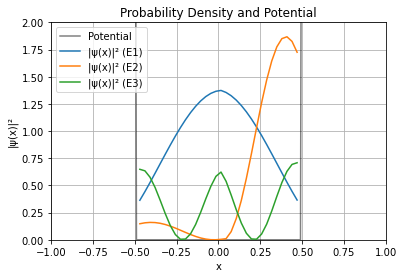

In [5]:
solutions = []

# Wrap the differential equations with the current energy guess
def wrapped_differential_equations(x, y):
    return differential_equations(x, y, [energy_guess])

# Wrap the boundary conditions with the current energy guess
def wrapped_boundary_conditions(ya, yb):
    return boundary_conditions(ya, yb, [energy_guess])

for i, energy_guess in enumerate(energies):
    
    # Solve the boundary value problem
    solution = solve_bvp(wrapped_differential_equations, wrapped_boundary_conditions, x_values, y_initial)
    solutions.append(solution)
    

# Plot potential and normalized wavefunction probability densities
x_plot = np.linspace(x_values.min(), x_values.max(), 200)
plt.plot(x_plot, potential_function(x_plot), color='k', alpha=0.5, label="Potential")

for i, solution in enumerate(solutions):
    wavefunction = solution.y[0]
    probability_density = wavefunction**2 / np.trapz(wavefunction**2, solution.x)
    
    mask = np.abs(solution.x) < 0.5  # Inside the well
    plt.plot(solution.x[mask], probability_density[mask], label=f"|ψ(x)|² (E{i+1})")


plt.xlabel("x")
plt.ylabel("|ψ(x)|²")
plt.ylim(0, 2)
plt.xlim(-1, 1)
plt.legend()
plt.title("Probability Density and Potential")
plt.grid(True)
plt.show()


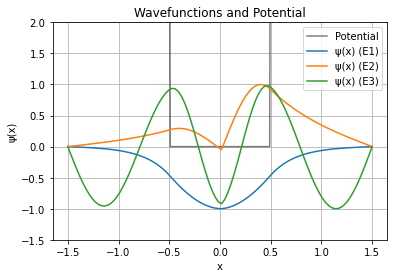

In [6]:
# Plot wavefunctions
x_plot = np.linspace(x_values.min(), x_values.max(), 200)
plt.plot(x_plot, potential_function(x_plot), color='k', alpha=0.5, label="Potential")

for i, solution in enumerate(solutions):
    
    wavefunction = solution.y[0]
    normalized_wavefunction = wavefunction / np.max(np.abs(wavefunction))
    plt.plot(solution.x, normalized_wavefunction, label=f"ψ(x) (E{i+1})")
    

plt.xlabel("x")
plt.ylabel("ψ(x)")
plt.ylim(-1.5, 2)
plt.legend()
plt.title("Wavefunctions and Potential")
plt.grid(True)
plt.show()


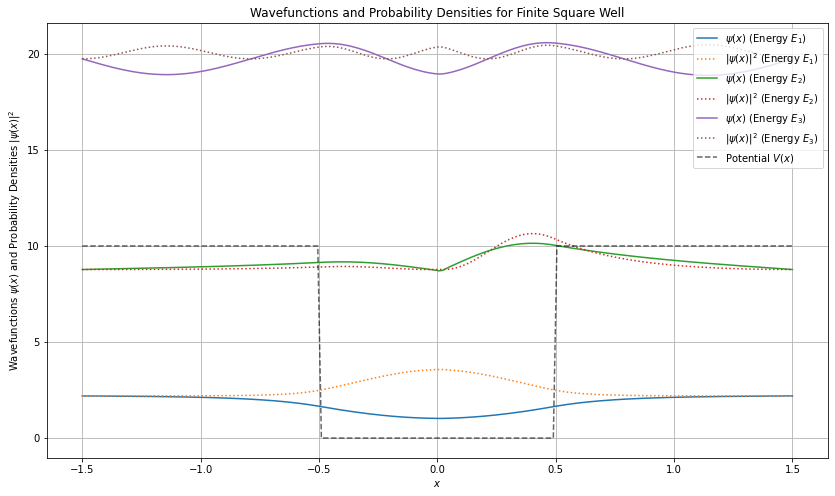

In [7]:
plt.figure(figsize=(14, 8)) 

# Plot each wavefunction and its probability density
for i, solution in enumerate(solutions):
    
    psi = solution.sol(x_plot)[0]
    psi /= np.sqrt(np.trapz(psi**2, x_plot)) 
    
    plt.plot(x_plot, psi + energies[i], label=f"$\psi(x)$ (Energy $E_{i+1}$)")
    plt.plot(x_plot, psi**2 + energies[i], label=f"$|\psi(x)|^2$ (Energy $E_{i+1}$)", linestyle="dotted")


potential = potential_function(x_plot)
plt.plot(x_plot, potential, label="Potential $V(x)$", color="black", linestyle="dashed", alpha=0.6)

plt.title("Wavefunctions and Probability Densities for Finite Square Well")
plt.xlabel("$x$")
plt.ylabel("Wavefunctions $\\psi(x)$ and Probability Densities $|\\psi(x)|^2$")
plt.legend()
plt.grid()
plt.show()


### Interpretation of Solutions


The wavefunction $\psi(x)$ has two distinct forms:

#### Inside the well $( |x| \leq a )$:
The potential $V(x) = -V_0 $, and the wavefunction oscillates sinusoidally:

$
 \psi(x) = A \cos(kx) + B \sin(kx),
$
where:
$
k = \sqrt{\frac{2m}{\hbar^2} (E + V_0)}.
$
    
#### Outside the well $( |x| > a )$:
The potential $ V(x) = 0 $, and the wavefunction decays exponentially due to the classically forbidden region.

$
\psi(x) = C e^{-\kappa x} \quad \text{for } x > a,
$  


$
\psi(x) = D e^{\kappa x} \quad \text{for } x < -a,
$
where:  

$
\kappa = \sqrt{\frac{2m}{\hbar^2} (V_0 - E)}.
$


We can see from the plot of wavefunctions that, inside the well, the wavefunctions do indeed oscillate sinusoidally and alternate parity with each energy level, starting with the ground state $ E_1 $ as an even function.

## Case 2: Quantum Harmonic Oscillator


### Provide Hamiltonian of System

$$
\
\Large
H = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)
\
$$







$$
\
V(x) = \frac{1}{2} m {\omega}^2 x^2
\
$$


In [8]:
def potential_function(x):
    return (1/2)*x**2

def boundary_conditions(ya, yb, p):
    return np.array([ya[1], yb[0]])


x_values = np.linspace(-20, 20, 100)
y_initial = np.zeros((2, x_values.size))
y_initial[0, :] = np.exp(-x_values**2 / 2)  # Approximation for ground state ψ(x)

### Provide guess for $E_n$ and solve BCP

We guess $E_n = \hbar \omega(n+\frac{1}{2})$, the energies of a quantum harmonic oscillator, where $n = 0, 1, 2...$.  


Keep in mind that we are working in natural units, so $E_n$ reduces to $E_n = n+\frac{1}{2}$.

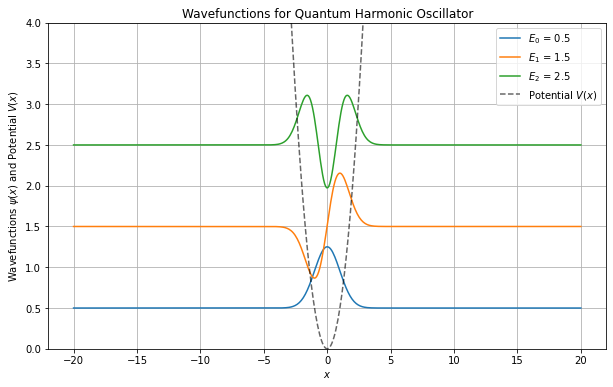

In [9]:
energy_guesses = [0.5, 1.5, 2.5]  


solutions = []
for energy_guess in energy_guesses:
    
    solution = solve_bvp(wrapped_differential_equations, wrapped_boundary_conditions, x_values, y_initial)
    solutions.append(solution)


x_plot = np.linspace(-20, 20, 500)
plt.figure(figsize=(10, 6))

for i, solution in enumerate(solutions):
    
    psi = solution.sol(x_plot)[0]
    psi /= np.sqrt(np.trapz(psi**2, x_plot)) 
    plt.plot(x_plot, psi + energy_guesses[i], label=f"$E_{i}$ = {energy_guesses[i]}")


potential = potential_function(x_plot)
plt.plot(x_plot, potential, label="Potential $V(x)$", color="black", linestyle="dashed", alpha=0.6)
plt.ylim(0, 4)
plt.title("Wavefunctions for Quantum Harmonic Oscillator")
plt.xlabel("$x$")
plt.ylabel("Wavefunctions $\\psi(x)$ and Potential $V(x)$")
plt.legend()
plt.grid()
plt.show()


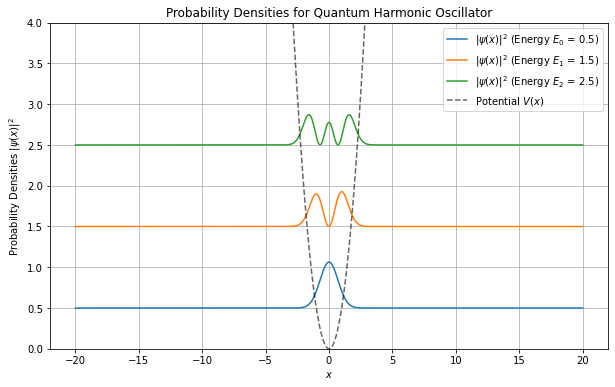

In [10]:
# Plot probability densities
plt.figure(figsize=(10, 6))

for i, solution in enumerate(solutions):
    
    psi = solution.sol(x_plot)[0]
    psi /= np.sqrt(np.trapz(psi**2, x_plot))  
        
    plt.plot(x_plot, psi**2 + energy_guesses[i], label=f"$|\psi(x)|^2$ (Energy $E_{i}$ = {energy_guesses[i]})")


potential = potential_function(x_plot)
plt.plot(x_plot, potential, label="Potential $V(x)$", color="black", linestyle="dashed", alpha=0.6)
plt.ylim(0, 4)
plt.title("Probability Densities for Quantum Harmonic Oscillator")
plt.xlabel("$x$")
plt.ylabel("Probability Densities $|\\psi(x)|^2$")
plt.legend()
plt.grid()
plt.show()

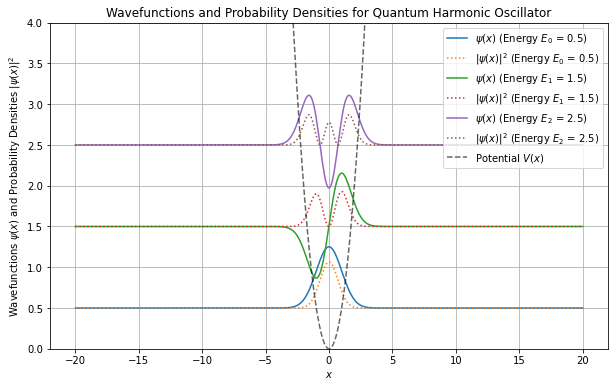

In [11]:
plt.figure(figsize=(10, 6))
for i, solution in enumerate(solutions):
    psi = solution.sol(x_plot)[0]
    
    psi /= np.sqrt(np.trapz(psi**2, x_plot))  
    
    plt.plot(x_plot, psi + energy_guesses[i], label=f"$\psi(x)$ (Energy $E_{i}$ = {energy_guesses[i]})")
    
    plt.plot(x_plot, psi**2 + energy_guesses[i], label=f"$|\psi(x)|^2$ (Energy $E_{i}$ = {energy_guesses[i]})", linestyle="dotted")


potential = potential_function(x_plot)
plt.plot(x_plot, potential, label="Potential $V(x)$", color="black", linestyle="dashed", alpha=0.6)
plt.ylim(0, 4)
plt.title("Wavefunctions and Probability Densities for Quantum Harmonic Oscillator")
plt.xlabel("$x$")
plt.ylabel("Wavefunctions $\\psi(x)$ and Probability Densities $|\\psi(x)|^2$")
plt.legend()
plt.grid()
plt.show()


### Interpretation of Solutions

The first graph depicts the wavefunctions themselves. For our wavefunctions, we can see that for each additional energy level, the number of peaks increases. This coincides with the expected form of the quantum harmonic oscillator eigenfunctions: the Hermite polynomials $H_n(x)$.

$$
\
\psi_n(x) = N_n H_n(x) e^{-x^2 / 2}
\
$$

Our second graph depicts the probability densities of each wavefunction, the probability of finding the particle in the system at x. The probability density of a wavefunction is given by $|\psi(x)|^2$. 



## Case 3: Time-Dependent Potentials


To time-evolve the wavefunction solutions, we can use the **time-dependent** Schrodinger Equation (in natural units):

$$
i\frac{\partial \psi(x,t)}{\partial t} = -\frac{1}{2} \nabla^2 \psi(x,t) + V(x,t) \psi(x,t)
$$  

In particular, for the finite potential well:

In [12]:
L = 5.0  # Length of the spatial domain
N = 512  # Number of spatial points
dx = 2 * L / N  # Spatial resolution
x = np.linspace(-L, L, N)  # Spatial grid
dt = 0.01  # Time step
t_max = 2.0  # Total simulation time
V0 = 10.0  # Potential barrier height

def potential_function(x):
    return np.where(np.abs(x) < 1, 0, V0)

V = potential_function(x)

# Initial wavefunction (Gaussian wave packet)
x0 = -2.0  
sigma = 0.5  
k0 = 5.0  
psi = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi /= np.sqrt(np.sum(np.abs(psi)**2) * dx)  

In [13]:
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)

kinetic_phase = np.exp(-1j * (k**2) * dt / 2)
potential_phase = np.exp(-1j * V * dt)

<IPython.core.display.Javascript object>


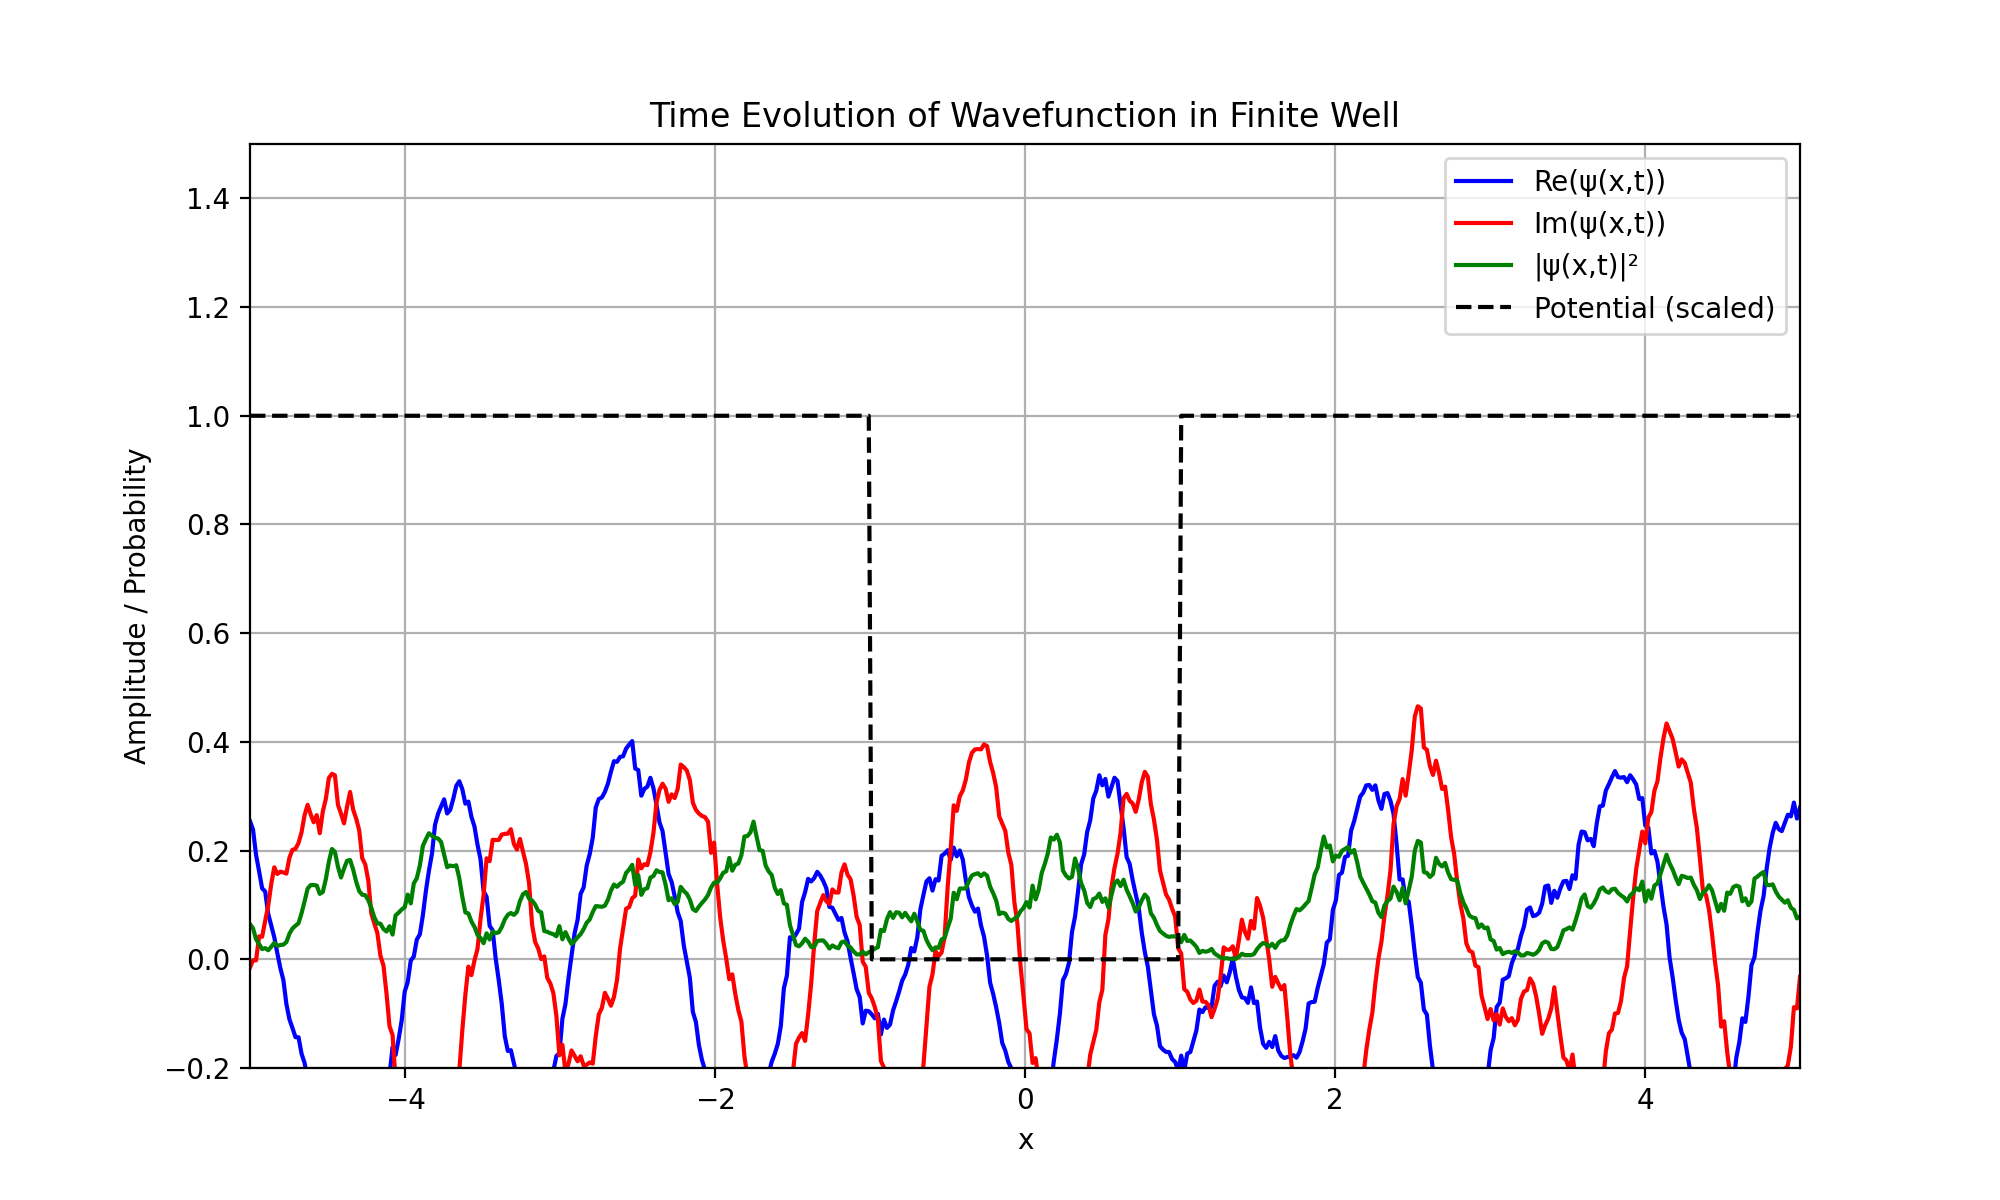

In [14]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig, ax = plt.subplots(figsize=(10, 6))
line_real, = ax.plot(x, np.real(psi), 'b-', label="Re(ψ(x,t))")
line_imag, = ax.plot(x, np.imag(psi), 'r-', label="Im(ψ(x,t))")
line_prob, = ax.plot(x, np.abs(psi)**2, 'g-', label="|ψ(x,t)|²")
line_potential, = ax.plot(x, V / V0, 'k--', label="Potential (scaled)")

ax.set_xlim(-L, L)
ax.set_ylim(-0.2, 1.5)
ax.set_xlabel("x")
ax.set_ylabel("Amplitude / Probability")
ax.set_title("Time Evolution of Wavefunction in Finite Well")
ax.legend()
ax.grid()

# Real-time evolution function
def update(frame):
    global psi
    
    # Apply half kinetic evolution (Fourier space)
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_phase
    psi = np.fft.ifft(psi_k)
    
    # Apply potential evolution (Position space)
    psi *= potential_phase
    
    # Apply half kinetic evolution again
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_phase
    psi = np.fft.ifft(psi_k)
    
    # Update the plot data
    line_real.set_ydata(np.real(psi))
    line_imag.set_ydata(np.imag(psi))
    line_prob.set_ydata(np.abs(psi)**2)
    return line_real, line_imag, line_prob


frames = int(t_max / dt) 
ani = FuncAnimation(fig, update, frames=frames, interval=20, blit=True)
plt.show()